# Защита персональных данных клиентов

**Описание проекта:** для защиты данных клиентов страховой компании необходимо разработать такой метод преобразования данных, чтобы было сложно восстановить персональную информацию. Преобразованные данные впоследствии должны использоваться в модели, предсказывающей количество страховых выплат для каждого клиента, поэтому преобразование не должно ухудшать качество модели.

**Цели проекта:** 
1. Разработать алгоритм защиты персональных данных клиентов.
2. Привести формальное и экспериментальное доказательства корректности его использования.

**Используемые данные:** набор персональных данных клиентов (`пол`, `возраст`, `зарплата` и количество `членов семьи` застрахованного, а также количество `страховых выплат` клиенту за последние пять лет.

## Оглавление
1. [Загрузка данных](#1)
2. [Умножение матриц](#2)
3. [Алгоритм преобразования](#3)
4. [Проверка алгоритма](#4)

<a id="1"></a>
## 1. Загрузка данных

Импортируем необходимые библиотеки и считаем файл с данными.

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("/datasets/insurance.csv")
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Посмотрим на общую информацию о данных.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Пропусков в данных нет, приводить признаки к каким-то другим типам не нужно.

Посмотрим на статистические характеристики признаков.

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Пол,5000.0,0.4990,0.500049,0.0,0.0,0.0,1.0,1.0
Возраст,5000.0,30.9528,8.440807,18.0,24.0,30.0,37.0,65.0
Зарплата,5000.0,39916.3600,9900.083569,5300.0,33300.0,40200.0,46600.0,79000.0
Члены семьи,5000.0,1.1942,1.091387,0.0,0.0,1.0,2.0,6.0
Страховые выплаты,5000.0,0.1480,0.463183,0.0,0.0,0.0,0.0,5.0


Каких-то аномалий в данных не видно. Построим шистограммы распределения признаков.

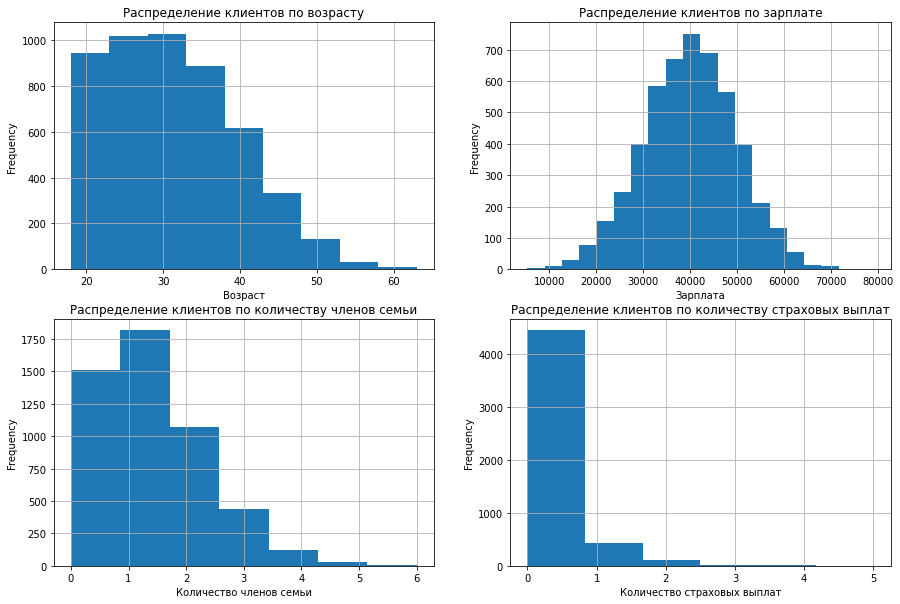

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

plt.subplot(2, 2, 1)
data["Возраст"].plot(kind="hist", bins=np.arange(18, 68, 5),
                     title="Распределение клиентов по возрасту",
                     grid=True)
plt.xlabel("Возраст")

plt.subplot(2, 2, 2)
data["Зарплата"].plot(kind="hist", bins=20,
                     title="Распределение клиентов по зарплате",
                     grid=True)
plt.xlabel("Зарплата")

plt.subplot(2, 2, 3)
data["Члены семьи"].plot(kind="hist", bins=7,
                     title="Распределение клиентов по количеству членов семьи",
                     grid=True)
plt.xlabel("Количество членов семьи")

plt.subplot(2, 2, 4)
data["Страховые выплаты"].plot(kind="hist", bins=6,
                     title="Распределение клиентов по количеству страховых выплат",
                     grid=True)
plt.xlabel("Количество страховых выплат")
plt.show()

**Вывод:** данные не требуют предобработки. 

<a id="2"></a>
## 2. Умножение матриц
Введём следующие обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Необходимо ответить на вопрос: **Изменится ли качество линейной регрессии при умножении матрицы признаков на обратимую матрицу?**

**Ответ:** качество линейной регрессии не изменится.

**Обоснование:** 

Пусть есть матрица признаков $X$ и некоторая обратимая матрица $P$. Умножим матрицу признаков на матрицу $P$ справа, результат умножения обозначим $\tilde{X}$:

$$\tilde{X} = XP.$$

Предположим, что предсказания модели изменятся, то есть

$$\tilde{a} = \tilde{X}\tilde{w}.$$

Тогда аналитическое решение для $\tilde{w}$:

$$\tilde{w} = (\tilde{X}^T \tilde{X})^{-1} \tilde{X}^T y$$

Подставим $XP$:

$$\tilde{w} = ((XP)^T XP)^{-1}(XP)^T y$$

Воспользуемся свойством транспонированных матриц, $(XP)^T = P^T X^T$:

$$\tilde{w} = (P^T X^T XP)^{-1} (XP)^T y$$

Для квадратных матриц $A$ и $B$ выполняется следующее: $(AB)^{-1} = B^{-1}A^{-1}$. Учтя это свойство, выполним преобразования: 

$$\tilde{w}  = P^{-1}(P^T X^T X)^{-1} (XP)^T y = $$

$$ = P^{-1}(P^T X^T X)^{-1} P^T X^T y = $$

$$ = P^{-1}(X^T X)^{-1} (P^T)^{-1} P^T X^T y$$

Учтём, что $(P^T)^{-1} P^T = E$, тогда:

$$\tilde{w} = P^{-1}(X^T X)^{-1} X^Ty,$$

то есть

$$\tilde{w} = P^{-1}w.$$

Тогда предсказания модели будут выглядеть так:

$$\tilde{a} = \tilde{X}\tilde{w} = XP P^{-1}w = Xw$$

Получили, что $\tilde{a} = a$, то есть предсказания не изменились, а значит, качество линейной регрессии при умножении матрицы признаков на обратимую матрицу справа **не изменится**.

<a id="3"></a>
## 3. Алгоритм преобразования
**Алгоритм**

Как было доказано выше, умножение матрицы признаков на обратимую матрицу справа не меняет качество регрессии. Этот факт можно использовать для преобразования исходных признаков. Создадим такую матрицу $P$, её можно сгенерировать из нормального распределения. Полученную матрицу умножим на матрицу признаков. Таким образом можно преобразовать данные, чтобы восстановить персональную информацию было сложно.

**Обоснование**

В п.2 формально доказано, что качество линейной регрессии при таком алгоритме преобразования не изменится. Даже зная конкретный вид распреления, из которого сгенерирована матрица $P$, будет затруднительно подобрать конкретно те значения, которые использовались для преобразования, чтобы получить исходные данные. Поэтому предложенный алгоритм можно использовать для защиты персональной информации клиентов.

<a id="4"></a>
## 4. Проверка алгоритма
Отделим признаки от целевой переменной, обучим модель линейной регрессии сначала на исходных данных, а затем на преобразованных, и сравним значения метрики $R^2$. Поскольку цель проекта не в создании наиболее качественной модели, не будем делить выборку на обучающую и тестовую, а также использовать стандартизацию. 


In [6]:
X = data.drop(columns="Страховые выплаты").values
y = data["Страховые выплаты"].values

In [7]:
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

In [8]:
np.random.seed(42)
m = X.shape[1]
P = np.random.normal(size=(m, m))
X_wave = X @ P

model = LinearRegression()
model.fit(X_wave, y)

y_pred_wave = model.predict(X_wave)

print("R2 для модели с исходными данными:       ", r2_score(y, y_pred))
print("R2 для модели с преобразованными данными:", r2_score(y, y_pred_wave))

R2 для модели с исходными данными:        0.42494550286668
R2 для модели с преобразованными данными: 0.4249455028666832


**Вывод:** значения $R^2$ совпадают с точностью до двух последних знаков; отличие, вероятно, связано с точностью округления при выполнении расчётов. Таким образом, предложенное преобразование данных действительно **не меняет** качество модели линейной регрессии.